## Bite size #1 

- Difference between binary cross-entropy and cross-entropy
- how do they behave when they have 2 classes and more

Formula of binary cross entropy loss

$\text{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p(y_i)) + (1 - y_i) \log(1 - p(y_i)) \right]$

Formula for multi-category cross entropy

$\text{CE} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} y_{ik} \log(p(y_{ik}))$


In [1]:
# np.eye() --> "eye" is a play on words: it sounds like "I", which is commonly used to denote the identity matrix in linear algebra
import numpy as np

# Generate random predictions and actual labels for N instances
N = 1000
y_pred = np.random.rand(N)  # Predicted probabilities for class 1
y_actual = np.random.randint(0, 2, N)  # Actual labels (0 or 1)

# Calculate Binary Cross-Entropy (BCE)
bce_loss = -np.mean(y_actual * np.log(y_pred) + (1 - y_actual) * np.log(1 - y_pred))

# Calculate Cross-Entropy (CE) for 2 classes
y_pred_0 = 1 - y_pred  # Predicted probabilities for class 0
y_actual_0 = 1 - y_actual  # Actual labels for class 0
ce_loss_2class = -np.mean(y_actual * np.log(y_pred) + y_actual_0 * np.log(y_pred_0))

# Generate predictions and actual labels for 3-class problem
y_pred_3class = np.random.rand(N, 3)  # Predicted probabilities for 3 classes
y_pred_3class = y_pred_3class / np.sum(y_pred_3class, axis=1, keepdims=True)  # Normalize to sum to 1
y_actual_3class = np.random.randint(0, 3, N)  # Actual labels (0, 1, or 2)
y_actual_3class_onehot = np.eye(3)[y_actual_3class]  # One-hot encode actual labels

# Calculate Cross-Entropy (CE) for 3 classes
ce_loss_3class = -np.mean(np.sum(y_actual_3class_onehot * np.log(y_pred_3class), axis=1))

bce_loss, ce_loss_2class, ce_loss_3class


(1.0261140715602373, 1.0261140715602373, 1.3430935021291543)

In [2]:
from scipy.special import xlogy
from sklearn.metrics import log_loss

# Calculate Binary Cross-Entropy (BCE) using Scipy
bce_loss_scipy = -np.mean(xlogy(y_actual, y_pred) + xlogy(1 - y_actual, 1 - y_pred))

# Calculate Cross-Entropy (CE) for 2 classes using Scikit-learn
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html
ce_loss_2class_sklearn = log_loss(y_actual, np.column_stack([y_pred_0, y_pred]))

# Calculate Cross-Entropy (CE) for 3 classes using Scikit-learn
ce_loss_3class_sklearn = log_loss(y_actual_3class, y_pred_3class)

bce_loss_scipy, ce_loss_2class_sklearn, ce_loss_3class_sklearn


(1.0261140715602373, 1.0261140715602373, 1.3430935021291541)

When there are only two classes (let's say class 0 and class 1), we can represent $y_0 = 1 - y_1$ and $y_1 = y$. Also, due to the softmax operation, $p_0 = 1-p$. Now we can rewrite the multi-class formula in terms of these variables and it would be the same as the binary cross entropy.

# Bite size #2
- difference between the input of F.binary_cross_entropy and F.cross_entropy
- https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html
- https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html


In [7]:
import torch
import torch.nn.functional as F

# Binary classification
# Input is probability after sigmoid
# input_prob = torch.tensor([1.7, 0.3], requires_grad=True) --> will get error
input_prob = torch.tensor([0.7, 0.3], requires_grad=True)
target = torch.tensor([1., 0.])
loss_binary = F.binary_cross_entropy(input_prob, target)
print(f"Binary Cross Entropy Loss: {loss_binary.item()}")

# Multi-class classification
# Input is raw logits before softmax
input_logits = torch.tensor([[1.5, -0.5], [0.5, 1.5]], requires_grad=True)
target = torch.tensor([0, 1])
loss_cross = F.cross_entropy(input_logits, target)
print(f"Cross Entropy Loss: {loss_cross.item()}")


Binary Cross Entropy Loss: 0.3566749691963196
Cross Entropy Loss: 0.22009485960006714


# Bite size #3
- how to define a custom callbacks in pytorch lightning to store tochmetrics Accuracy values

To use a custom callback to log validation accuracy at the end of each validation epoch. We utilizes the torchmetrics library to compute the accuracy. Callbacks allow to execute some code at a certain point via hooks.

For a list of callbacks:
https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html

In [ ]:
from lightning.pytorch.callbacks import Callback
import torchmetrics

val_metric = []

class CustomCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        # compute() calculates the value and returns a tensor
        # .item() to get value of tensor
        accuracy = pl_module.val_acc.compute().item()
        val_metric.append(accuracy)
        print(f"val_metric: {val_metric}")


# Bite Size #4
- to get model parameters
- to get learning rate change by epoch

How to retrieve a model's parameters using model.parameters() and track learning rate adjustments through a scheduler

In [4]:
import torch
import torch.nn as nn

# Define a simple model
model = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 1)
)

# Print the size of each parameter in the model
for param in model.parameters():
    print(param.size())

# Initialize optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Create a list to store the learning rates obtained at each manual step
manual_lrs = []

# Record learning rates over 5 steps
for _ in range(5):
    optimizer.step()
    scheduler.step()
    manual_lrs.append(optimizer.param_groups[0]["lr"])

# Output the learning rates recorded at each manual step
manual_lrs

torch.Size([20, 10])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


[0.09997532801828658,
 0.09990133642141358,
 0.099778098230154,
 0.0996057350657239,
 0.09938441702975688]

# Bite Size #5
- how to log metrics and parameters locally

In [ ]:
 # to log locally via CSVLogger using Trainer
trainer = L.Trainer(
    max_epochs=10, accelerator="cpu", devices=1, deterministic=True,
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    callbacks=[CustomCallback()]
)

# to define metrics to save with self.log
class LightningModel(L.LightningModule):
    ...
    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("custom_loss", loss)

# to get directory of logs
trainer.logger.log_dir

# Bite Size #6
- to log custom callbacks metrics 

In [ ]:
from lightning.pytorch.callbacks import Callback
import torchmetrics


class CustomCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):
        # compute() calculates the value and returns a tensor
        # .item() to get value of tensor
        val_accuracy = pl_module.val_acc.compute().item()
        self.log("val_epoch_end_acc", val_accuracy)


Pytorch lightning overall structure

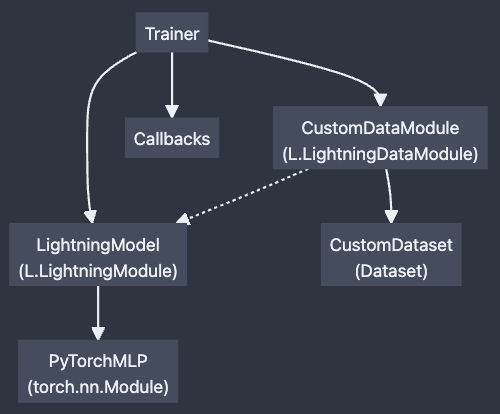